In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
import mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings(action='ignore')

# data load

## 뉴스데이터

In [2]:
path = '..\데이터\기업별 뉴스'

In [3]:
import os
file_list = os.listdir(path)
len(file_list)

140

In [4]:
file_name = []
for file in file_list:
    if file.count(".") == 1: 
        name = file.split('.')[0]
        file_name.append(name)
    # else:
    #     for k in range(len(file)-1,0,-1):
    #         if file[k]=='.':
    #             file_name.append(file[:k])
    #             break

In [5]:
file_name[:5]

['CMG제약', 'HLB생명과학', 'JW생명과학', 'JW신약', 'JW중외제약']

In [6]:
df1 = []
for 기업 in file_name:
    df =pd.read_excel(f"../데이터/기업별 뉴스/{기업}.xlsx",sheet_name='#02 Documents')#,header=0,skiprows=[1,2])
    # df = df[['Unnamed: 2','20221231','20211231','20201231','20191231','20181231']]
    df = pd.DataFrame(df)
    df1.append(df)
len(df1)

140

In [7]:
df2 =[]
for df in df1:
    df = df[['title','polarity.label']]
    df['polarity.label'] = df['polarity.label'].replace(-1,2)
    # dupli = df[df.duplicated()]
    df.drop_duplicates(subset=['title'], inplace=True)
    df2.append(df)
    # duplicate_list.append(dupli)

In [8]:
len(df2)

140

In [9]:
df2[49].head(2)

,title,polarity.label
0,[취재 일지]세계는 여전히 ‘건기식’ 열풍… 경쟁력 높이려면 식약처 기준 완화돼야,NaN
1,"어린이 프로바이오틱스, 유산균도 가격도 천차만별…따져보고 사야",NaN


In [10]:
train = []
test  = []
for df in df2:
    tmp_train = df[df['polarity.label'].notna()]
    tmp_test = df[df['polarity.label'].isna()]
    train.append(tmp_train)
    test.append(tmp_test)

In [11]:
len(train), len(test)

(140, 140)

In [12]:
test1 =[]
for df in test:
    # df['tokenized'] = df['title'].apply(mecab.morphs)
    df['labels'] = df['polarity.label']
    df = df.drop('polarity.label', axis = 1)
    # df = df[['labels','tokenized']]
    test1.append(df)

In [13]:
train1 =[]
for df in train:
    df['labels'] = df['polarity.label']
    df = df.drop('polarity.label', axis = 1)
    train1.append(df)

In [14]:
test_df = pd.concat(test1, axis = 0)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22828 entries, 0 to 411
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   22828 non-null  object 
 1   labels  0 non-null      float64
dtypes: float64(1), object(1)
memory usage: 535.0+ KB


In [15]:
train_df = pd.concat(train1, axis = 0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18038 entries, 2 to 408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   18038 non-null  object 
 1   labels  18038 non-null  float64
dtypes: float64(1), object(1)
memory usage: 422.8+ KB


In [16]:
len(test_df)

22828

In [17]:
# test_df


## 금융뉴스 데이터

In [18]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x186020e9a90>)

In [19]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [20]:
data['labels'] = data['labels'].replace(['neutral', 'positive', 'negative'],[0, 1, 2])
data['title'] = data['kor_sentence']
data = data.drop('kor_sentence',axis=1)
data[:5]

,labels,sentence,title
0,0,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [21]:
del data['sentence']

In [22]:
data[:5]

,labels,title
0,0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,0,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,1,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,1,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


## 중복제거

In [23]:
duplicate_test = test_df[test_df.duplicated()]
duplicate_train = train_df[train_df.duplicated()]

In [24]:
duplicate_test = duplicate_test.sort_values(by='title')
duplicate_train = duplicate_train.sort_values(by='title')

In [25]:
# 중복 제거
test=test_df.drop_duplicates(subset=['title'])
train=train_df.drop_duplicates(subset=['title'])
data = data.drop_duplicates(subset=['title'])

# print('총 샘플의 수 :',len(data))

In [26]:
len(test),len(train)

(17109, 16074)

# 데이터 통합

In [27]:
df = pd.concat([data,train])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20901 entries, 0 to 406
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   labels  20901 non-null  float64
 1   title   20901 non-null  object 
dtypes: float64(1), object(1)
memory usage: 489.9+ KB


# 라벨 분포

In [28]:
# train['labels'].value_counts().plot(kind='bar')

<AxesSubplot: >

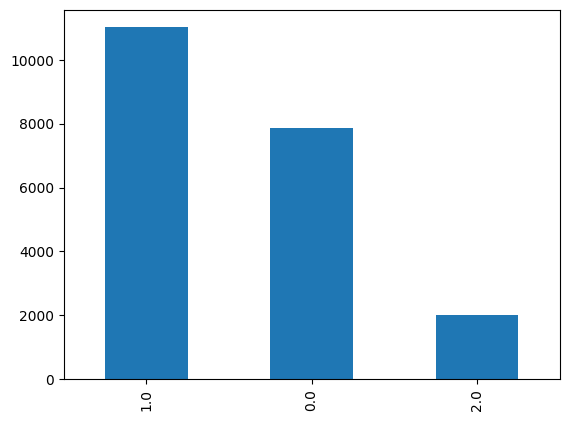

In [29]:
df['labels'].value_counts().plot(kind='bar')

In [30]:
# print(f'중립의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')
# print(f'긍정의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
# print(f'부정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')

In [31]:
print(f'중립의 비율 = {round(df["labels"].value_counts()[0]/len(df) * 100,3)}%')
print(f'긍정의 비율 = {round(df["labels"].value_counts()[1]/len(df) * 100,3)}%')
print(f'부정의 비율 = {round(df["labels"].value_counts()[2]/len(df) * 100,3)}%')

중립의 비율 = 37.644%
긍정의 비율 = 52.706%
부정의 비율 = 9.65%


## 라벨 분포 조정
* 긍정 -> 절반으로
* 부정 -> 두배 복제

### 긍정

In [32]:
df_pos=df[df["labels"]==1]
df_neg=df[df["labels"]==2]
df_neu=df[df["labels"]==0]

In [33]:
len(df_pos),len(df_neg)

(11016, 2017)

In [34]:
df_pos = df_pos.reset_index(drop=True)

In [35]:
pos_len = round(len(df_pos)/2)

In [36]:
df_pos = df_pos[:pos_len]

In [37]:
len(df_pos)

5508

### 부정

In [38]:
df_neg = df_neg.append(df_neg)

In [39]:
len(df_neg)

4034

## 라벨 분포 확인

In [40]:
df = pd.concat([df_pos,df_neg,df_neu])
# train.head(1)
len(df)

17410

In [41]:
# df.to_csv('./df_label_O.csv', index=False)

In [42]:
print(f'중립의 비율 = {round(df["labels"].value_counts()[0]/len(df) * 100,3)}%')
print(f'긍정의 비율 = {round(df["labels"].value_counts()[1]/len(df) * 100,3)}%')
print(f'부정의 비율 = {round(df["labels"].value_counts()[2]/len(df) * 100,3)}%')

중립의 비율 = 45.192%
긍정의 비율 = 31.637%
부정의 비율 = 23.171%


In [43]:
# data.shape, train.shape

In [44]:
mecab = mecab.MeCab()

In [45]:
df['tokenized'] = df['title'].apply(mecab.morphs)

In [46]:
df.head(2)

,labels,title,tokenized
0,1.0,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,"[새로운, 생산, 공장, 으로, 인해, 회사, 는, 예상, 되, 는, 수요, 증가,..."
1,1.0,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...","[2009, -, 2012, 년, 회사, 의, 업데이트, 된, 전략, 에, 따르, ..."


In [47]:
df['tokenized'].iloc[0]

['새로운',
 '생산',
 '공장',
 '으로',
 '인해',
 '회사',
 '는',
 '예상',
 '되',
 '는',
 '수요',
 '증가',
 '를',
 '충족',
 '시킬',
 '수',
 '있',
 '는',
 '능력',
 '을',
 '증가',
 '시키',
 '고',
 '원자재',
 '사용',
 '을',
 '개선',
 '하',
 '여',
 '생산',
 '수익',
 '성',
 '을',
 '높일',
 '것',
 '이',
 '다',
 '.']

In [48]:
# X_train = pd.read_csv('./X_train_token.csv')
# X_train = X_train['tokenized']

# train - validation

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17410 entries, 0 to 378
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   labels     17410 non-null  float64
 1   title      17410 non-null  object 
 2   tokenized  17410 non-null  object 
dtypes: float64(1), object(2)
memory usage: 544.1+ KB


In [50]:
X=df['tokenized']
y=df['labels']

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [52]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_val))

훈련 샘플의 개수 : 13928
테스트 샘플의 개수 : 3482


In [53]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 45.19%
긍정 = 31.641%
부정 = 23.169%


In [54]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_val.value_counts()[0]/len(y_val) * 100,3)}%')
print(f'긍정 = {round(y_val.value_counts()[1]/len(y_val) * 100,3)}%')
print(f'부정 = {round(y_val.value_counts()[2]/len(y_val) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 45.204%
긍정 = 31.62%
부정 = 23.176%


# Tokenize

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)
print(X_train_encoded[:5])
print(X_val_encoded[:5])

[[49, 5, 1352, 156, 106, 2955, 144, 1084, 39, 455, 370, 212, 149, 3945, 18, 361, 42, 9, 2366, 39, 77, 34, 232, 26, 42, 122, 16, 18, 34, 179, 64, 34, 112, 5, 130, 234, 4457, 2, 84, 31, 36, 4, 46, 74, 1138, 2, 25, 31, 36, 157, 147, 20, 7, 2], [2718, 548, 348, 17, 6, 502, 41, 418, 187, 10, 357, 1, 226, 75, 304, 762], [8, 778, 1046, 15, 204, 13, 1, 426, 1723, 58, 636, 6615, 66, 353, 15], [129, 737, 162, 585, 1, 510, 4458, 3211, 217, 1649, 2542, 1517], [8, 86, 9, 520, 16, 25, 34, 18, 6616, 19, 779, 138, 126, 8, 6617, 9341, 751, 564, 5, 2956, 9342, 1990, 70, 6, 1404, 37, 1115, 70, 81, 7, 2]]
[[11, 63, 35, 12, 57, 76, 62, 1708, 126, 10, 116, 493], [57, 9255, 1011, 1996, 885, 1714, 85, 10, 375, 169, 162, 61, 24, 379, 14149, 3, 1286, 3], [40, 196, 514, 554, 856, 44, 47, 5, 4341, 294, 70, 85], [399, 27, 55, 46, 74, 678, 21, 48, 3, 83, 1373, 1479, 7391, 99, 315, 1472, 2, 77, 260], [8, 3596, 9, 311, 613, 408, 53, 512, 1061, 14, 1607, 37, 159, 2]]


In [56]:
word_to_index = tokenizer.word_index
vocab_size = len(word_to_index) + 1
print(vocab_size)

16523


## 패딩

In [57]:
X_train[:2]

2098    [핀란드, 의, 부품, 공급, 업체, 컴포넌트, 아, 코퍼레이션, (, OMX, 헬...
3952    [인지, 기능, 개선, 하, 는, 프로, 바이오, 틱, 스, …, 동화약품, ,, ...
Name: tokenized, dtype: object

본문의 최대 길이 : 76
본문의 평균 길이 : 19.33543940264216


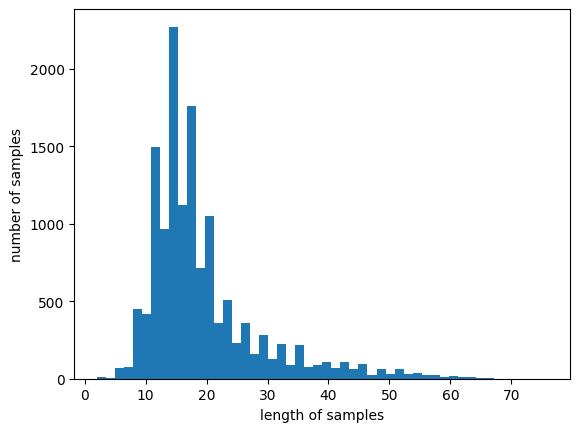

In [58]:
print(  '본문의 최대 길이 :',   max(   len(sent) for sent in X_train   )   )
# X_train 요소 하나하나 길이 재서 최대길이추출
print(   '본문의 평균 길이 :',  sum(    map(len, X_train)  )   /  len(X_train)     )
# X_train 요소 길이 재서 sum하구 X_train 개수로 나눈다
plt.hist([len(sent) for sent in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [59]:
max_len = 76

In [60]:
X_train_encoded = pad_sequences(X_train_encoded, maxlen=max_len)
X_val_encoded = pad_sequences(X_val_encoded, maxlen=max_len)

In [61]:
X_train_encoded.shape

(13928, 76)

In [62]:
X_val_encoded.shape

(3482, 76)

In [63]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

# 모델
*  테스트 정확도: 0.8441

In [64]:
embedding_dim = 64
hidden_units = 64
num_classes = 3

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./NLP/best_model_label_balanced.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train_encoded, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
349/349 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.7094
Epoch 1: val_acc improved from -inf to 0.79289, saving model to ./NLP\best_model_label_balanced.h5
349/349 [==============================] - 14s 34ms/step - loss: 0.6794 - acc: 0.7094 - val_loss: 0.5094 - val_acc: 0.7929
Epoch 2/15
349/349 [==============================] - ETA: 0s - loss: 0.2844 - acc: 0.8935
Epoch 2: val_acc improved from 0.79289 to 0.84781, saving model to ./NLP\best_model_label_balanced.h5
349/349 [==============================] - 12s 33ms/step - loss: 0.2844 - acc: 0.8935 - val_loss: 0.3909 - val_acc: 0.8478
Epoch 3/15
349/349 [==============================] - ETA: 0s - loss: 0.1464 - acc: 0.9479
Epoch 3: val_acc did not improve from 0.84781
349/349 [==============================] - 12s 36ms/step - loss: 0.1464 - acc: 0.9479 - val_loss: 0.4677 - val_acc: 0.8403
Epoch 4/15
348/349 [============================>.] - ETA: 0s - loss: 0.0851 - acc: 0.9712
Epoch 4: val_acc did

In [65]:
loaded_model = load_model('./NLP/best_model_label_balanced.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_val_encoded, y_val)[1]))

109/109 [==============================] - 1s 8ms/step - loss: 0.3991 - acc: 0.8441

 테스트 정확도: 0.8441


# Test

In [66]:
test.head()

,title,labels
0,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN
1,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",NaN
6,오늘은 ‘세계 강아지의 날’ “반려견 건강 챙겨주세요”,NaN
7,펫 의약품 가파른 성장세… 제약·바이오 기업 바빠졌다,NaN
8,"안국약품, CMG제약과 고혈압·고지혈증 복합제 '아모르탄알정' 코프로모션",NaN


In [67]:
test['tokenized'] = test['title'].apply(mecab.morphs)

In [68]:
test.head(2)

,title,labels,tokenized
0,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",NaN,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
1,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",NaN,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."


In [69]:
X_test=test['tokenized']
y_test=test['labels']

In [70]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_encoded = pad_sequences(X_test_encoded, maxlen=max_len)

In [71]:
pred_vals=model.predict(X_test_encoded)

535/535 [==============================] - 5s 9ms/step


In [72]:
labels =[]
for pred in pred_vals:
    label = np.argmax(pred)
    labels.append(label)

In [73]:
labels[:2]

[0, 1]

In [74]:
test['labels'] = labels

In [75]:
len(test[test['labels']==0]),len(test[test['labels']==1]),len(test[test['labels']==2])

(9178, 5935, 1996)

In [76]:
test_neu=test[test['labels']==0]
test_neu.head()

,title,labels,tokenized
0,"차병원·바이오그룹, R&D·영업마케팅 경력 공개 채용",0,"[차, 병원, ·, 바이오, 그룹, ,, R, &, D, ·, 영업, 마케팅, 경력..."
6,오늘은 ‘세계 강아지의 날’ “반려견 건강 챙겨주세요”,0,"[오늘, 은, ‘, 세계, 강아지, 의, 날, ’, “, 반려, 견, 건강, 챙겨,..."
10,"차바이오텍 계열사 CMG제약, 동물의약품 사업부 신설",0,"[차바, 이, 오텍, 계열사, CMG, 제약, ,, 동물, 의약품, 사업, 부, 신설]"
13,"안국약품, CMG제약과 정장제 '락비오캡슐' 코프로모션",0,"[안국, 약품, ,, CMG, 제약, 과, 정장제, ', 락, 비, 오, 캡슐, '..."
25,“미리어드만의 생태계 만들겠다”…바이오 투자사 설립한 까닭은,0,"[“, 미리, 어드만, 의, 생태, 계, 만들, 겠, 다, ”, …, 바이, 오, ..."


In [77]:
test_pos=test[test['labels']==1]
test_pos.head()

,title,labels,tokenized
1,"""매출, 올해 50%·내년 두배 ↑""…마더스제약, 성장 자신하는 이유",1,"["", 매출, ,, 올해, 50, %·, 내년, 두, 배, ↑""…, 마더, 스, 제..."
7,펫 의약품 가파른 성장세… 제약·바이오 기업 바빠졌다,1,"[펫, 의약품, 가파른, 성장세, …, 제약, ·, 바이오, 기업, 바빠졌, 다]"
8,"안국약품, CMG제약과 고혈압·고지혈증 복합제 '아모르탄알정' 코프로모션",1,"[안국, 약품, ,, CMG, 제약, 과, 고, 혈압, ·, 고지혈증, 복합제, '..."
9,"차바이오텍 CMG제약, 동물의약품 사업진출",1,"[차바, 이, 오텍, CMG, 제약, ,, 동물, 의약품, 사업, 진출]"
11,CMG제약 “신약 개발로 2025년 연매출 2000억 30위권 제약사 도약”,1,"[CMG, 제약, “, 신약, 개발, 로, 2025, 년, 연매, 출, 2000, ..."


In [78]:
test_neg=test[test['labels']==2]
test_neg.head()

,title,labels,tokenized
55,공매도 금지 6개월 연장…코스닥 제약·바이오株에 기름 부을까,2,"[공매도, 금지, 6, 개월, 연장, …, 코스닥, 제약, ·, 바이오, 株, 에,..."
63,"코스닥, 中 코로나 우려에 하락 출발…710선",2,"[코스닥, ,, 中, 코, 로, 나, 우려, 에, 하락, 출발, …, 710, 선]"
75,[코스닥 마감]개인 반발 매수에 낙폭 축소하며 780선… 1.74%↓,2,"[[, 코스닥, 마감, ], 개인, 반발, 매수, 에, 낙폭, 축소, 하, 며, 7..."
103,"코스닥, 전주 부진 딛고 3% 반등…773.22",2,"[코스닥, ,, 전주, 부진, 딛, 고, 3, %, 반, 등, …, 773, ., 22]"
105,약세장서 '공매도 과열종목제' 무용…개미들 '부글',2,"[약세, 장서, ', 공매도, 과열, 종목, 제, ', 무용, …, 개미, 들, '..."
